In [ ]:
import tweepy
import time
import csv
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive')

In [ ]:
#df = pd.read_parquet('twitter_data.parquet')
#df.drop_duplicates(subset=['tweet_id'])

# new 

In [ ]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util

In [ ]:
def clean_data(filename: str):
    def remove_emojis(data):
        emoj = re.compile("["
                          u"\U0001F600-\U0001F64F"  # emoticons
                          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                          u"\U0001F680-\U0001F6FF"  # transport & map symbols
                          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          u"\U00002500-\U00002BEF"  # chinese char
                          u"\U00002702-\U000027B0"
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          u"\U0001f926-\U0001f937"
                          u"\U00010000-\U0010ffff"
                          u"\u2640-\u2642"
                          u"\u2600-\u2B55"
                          u"\u200d"
                          u"\u23cf"
                          u"\u23e9"
                          u"\u231a"
                          u"\ufe0f"  # dingbats
                          u"\u3030"
                          "]+", re.UNICODE)
        return re.sub(emoj, '', data)

    # Removing mentions and hashtags and url
    def remove_mentions_and_tags(text):
        text = re.sub(r'@\S*', '', text)
        text = re.sub(r'http\S+', '', text)
        return re.sub(r'#\S*', '', text)

    read_df = pd.read_parquet(filename)
    read_df = read_df.loc[read_df['tweet_type'] != 'retweet']
    read_df = read_df.drop_duplicates(subset=['tweet_id'], ignore_index=True)
    read_df.text = read_df.text.apply(remove_emojis)
    read_df.text = read_df.text.apply(remove_mentions_and_tags)
    read_df['text'] = read_df['text'].str.replace(
        r'[^\w\s]+', '')  # remove punctuations
    read_df['text'] = read_df['text'].str.replace('\d+', '')  # removes number
    

    return read_df












def print_beauty(df, word_topic_df):
    for i in range(6, 10):
        print('Tweet:', df.iloc[i].Tweet)
        print('Hashtags:', df.iloc[i].Hashtags)
        print('Topic_Probability:', df.iloc[i].Topic_Probability)
        print("----------------------------------------------------------------\n")

    for i in range(4):
        print("Topic ", (i+1))
        print("Most Probable Word List: ",
              word_topic_df.iloc[i].most_prob_words)
        print("-------------------------------------------------------\n")







In [ ]:
read_df = clean_data("twitter_data.parquet")

<ipython-input-10-9455a7364e49>:36: FutureWarning: The default value of regex will change from True to False in a future version.
  read_df['text'] = read_df['text'].str.replace(
<ipython-input-10-9455a7364e49>:38: FutureWarning: The default value of regex will change from True to False in a future version.
  read_df['text'] = read_df['text'].str.replace('\d+', '')  # removes number


In [ ]:
def extract_most_frequent_hashtags(df):
    dates = list()

    for row, record in enumerate(df.hashtags):
        if record != '[]' and df['timestamp'][row][0:7] > '2021-05':
            dates.append(df['timestamp'][row][0:7])
    date = list()
    for dt in dates:
        if dt not in date:
            date.append(dt)

    i = 1
    j = 6
    for i in range(1, 3):
        for j in range(1, 13):
            if i == 1 and j > 5 and j < 10 or i == 2 and j < 10:
                globals()[f'hash202{i}_0{j}'] = list()
                globals()[f'hash202{i}_0{j}'].extend([hash for row, hash in enumerate(
                    df['hashtags']) if df['timestamp'][row][0:7] == f'202{i}-0{j}' and hash != '[]'])

            elif i == 1 and j > 5 and j >= 10 or i == 2 and j >= 10:
                globals()[f'hash202{i}_{j}'] = list()
                globals()[f'hash202{i}_{j}'].extend([hash for row, hash in enumerate(
                    df['hashtags']) if df['timestamp'][row][0:7] == f'202{i}-{j}' and hash != '[]'])

    # preprocessing the hashtags list from specific periods
    i = 1
    j = 6
    for i in range(1, 3):
        for j in range(1, 13):
            if i == 1 and j > 5 and j < 10 or i == 2 and j < 10:
                globals()[f'all_hashtags_202{i}_0{j}'] = list()
                for s in globals()[f'hash202{i}_0{j}']:
                    bb = s.split(', ')
                    a = [re.search(r"[\[\'\"]*(\w*)[\]\']*", i).group(1)
                         for i in bb]
                    globals()[f'all_hashtags_202{i}_0{j}'].extend(a)

            elif i == 1 and j > 5 and j >= 10 or i == 2 and j >= 10:
                globals()[f'all_hashtags_202{i}_{j}'] = list()
                for s in globals()[f'hash202{i}_{j}']:
                    bb = s.split(', ')
                    a = [re.search(r"[\[\'\"]*(\w*)[\]\']*", i).group(1)
                         for i in bb]
                    globals()[f'all_hashtags_202{i}_{j}'].extend(a)

    def hashtag_set_finder():
        hashtag_set = set()
        for dt in date:
            i, j = dt[3], dt[5:]
            lis = globals()[f'all_hashtags_202{i}_{j}']
            for i in lis:
                hashtag_set.add(i)
        return hashtag_set
    hashtags_in_DS = hashtag_set_finder()
    hashtags_in_DS2 = {i.lower() for i in hashtags_in_DS}

    def generate_hashtags(dataset):
        listOfAllHashtags = list()
        for row, hash in enumerate(dataset.hashtags):
            if dataset['timestamp'][row][0:10] >= "2021-06-01" and hash != '[]':
                bb = hash.split(', ')

                a = [re.search(r"[\[\']*(\w*)[\]\']*", i).group(1) for i in bb]
                listOfAllHashtags.extend(a)
        listOfAllHashtagsL = [i.lower() for i in listOfAllHashtags]
        return listOfAllHashtagsL
    list_of_all_hashtags = generate_hashtags(df)
    dic_of_mfh = {i: list_of_all_hashtags.count(
        i)/len(list_of_all_hashtags) for i in hashtags_in_DS2 if list_of_all_hashtags.count(i) > 20}
    #input_hashtags = [i[0] for i in list_of_mfh]
    return dic_of_mfh


def hashtag_groups(df):
    representative_hashtags = list()
    model = SentenceTransformer('T-Systems-onsite/cross-en-de-roberta-sentence-transformer')
    dic_of_mfh = extract_most_frequent_hashtags(df)
    input_hashtags = list(dic_of_mfh.keys())
    sentence = input_hashtags
    clusterd_hashtags = list()
    for hash in input_hashtags:
        embedding = model.encode(hash)
        sublist = {hash}
        for j in range(len(input_hashtags)):
            if j < len(input_hashtags)-1:
                if util.pytorch_cos_sim(embedding, model.encode(input_hashtags[j+1])) > 0.5:
                    sublist.add(input_hashtags[j+1])
                    input_hashtags.remove(input_hashtags[j+1])
        clusterd_hashtags.append(sublist)

        clusterd_hashtags.sort(reverse=True, key=lambda i: len(i))
    print("for each cluster a group name has been extracted based on the most frequent hashtag of that group or a Group Representative\n")
    for i in clusterd_hashtags:
        i = list(i)
        group_n = i[0]
        for j in i:
            if dic_of_mfh[j] > dic_of_mfh[group_n]:
                group_n = j
        representative_hashtags.append(group_n)
        print(f"group name  :  {group_n}")
        print(f'{i}\n')
    return representative_hashtags,clusterd_hashtags


def tweet_clustering(df, tweet_id, rep_hashtags, model):
  hashclusters = set()
  tweet_hashtags = list()
  hashtags = str(list(df[df.tweet_id == tweet_id].hashtags))
  hashtags = hashtags.split(', ')
  a = [re.search(r"[\[\'\"]*(\w*)[\]\']*", i).group(1) for i in hashtags]
  tweet_hashtags.extend(a)
  #print(a)
  if not tweet_hashtags[0]:
    print("no hashtags found for this tweet")
    return

  for tw_hash in tweet_hashtags:
    embedding = model.encode(tw_hash)
    highestsim=0
    hash=""
    for rep_hash in rep_hashtags:
        sim=util.pytorch_cos_sim(embedding, model.encode(rep_hash))
        if  sim> 0.5 and sim>highestsim:
          highestsim=sim
          hash=rep_hash
            
    hashclusters.add(hash)


        
  if not hashclusters:
    print("hashtags in this tweet are very infrequent and disimilar to the founded groups") 
  return list(hashclusters)

In [ ]:
representative_hashtgas,clustered_hashtags=hashtag_groups(read_df)

for each cluster a group name has been extracted based on the most frequent hashtag of that group or a Group Representative

group name  :  berlhg
['ugnovelle', 'dfg', 'hrk', 'scholz', 'berlhg', 'guttenberg', 'bafög', 'bmbf', 'bafög50', 'karliczek', 'abo', 'lehre', 'bipocs', 'phdlife', 'baerbock', 'göttingen']

group name  :  hochschulen
['entfristethanna', 'hochschulpolitik', 'tvstudjetzt', 'streiksemester', 'nachwuchs', 'hochschulen', 'hochschulendemokratisieren', 'ausstieghochschule', 'hochschule', 'trump']

group name  :  dauerstellen
['zeitverträge', 'dauerstellenfürdaueraufgaben', 'befristungen', 'befristung', 'überstunden', 'entfristung', 'daueraufgaben', 'zwangsteilzeit', 'dauerstellen', 'arbeitszeiterfassung']

group name  :  ichwarhanna
['hannainzahlen', 'ichwarhanna', 'hannawählt', 'hanna', 'woisthanna', 'hannaorganisiertsich', 'wirsindhanna', 'hannagehtwählen']

group name  :  unigöttingen
['unigöttingen', 'hitzefrei', 'jlugiessen', 'freibad', 'wissenschaftsfreiheit', 'mitt

In [ ]:
len(representative_hashtgas)

52

In [ ]:
representative_hashtgas

['berlhg',
 'hochschulen',
 'dauerstellen',
 'ichwarhanna',
 'unigöttingen',
 'ichbinhanna',
 'academia',
 'tvstud',
 'deutschlanddeineschulden',
 'wissenschaft',
 'arbeiterkind',
 'hannaimbundestag',
 'unionize',
 'weilwirwissenschaftlieben',
 'anschlussverwendung',
 'btw21',
 'waspostdocswollen',
 'arbeitsbedingungen',
 'forschung',
 'mlunterfinanziert',
 'streik',
 'wisskomm',
 'mehrhabeck',
 'openaccess',
 'zukunftsvertrag',
 'koalitionsvertrag',
 'wohlstand',
 'ampel',
 'sachsenanhalt',
 'wissenschaftszeitvertragsgesetz',
 'wisszeitvg',
 'bundestag',
 'twittercampus',
 '95vswisszeitvg',
 'unverzichtbar',
 'mint',
 'digitalisierung',
 'innovation',
 'personalentwicklung',
 'mentalhealth',
 'hrkadvent',
 'frististfrust',
 'pandemie',
 'corona',
 'stopthecuts',
 'acertaindegreeofflexibility',
 'thesis_ev',
 'einkaufszentrum',
 'speakupostbelgien',
 'keineausnahme',
 'bipoc',
 'dasgewinnenwir']

In [ ]:
# saving the clustered_hashtags
import pickle
with open('clusterd_hashtags_52.txt','wb') as file:
  pickle.dump(representative_hashtgas, file) 
#with open('clusterd_hashtags.txt','rb') as f:
#  clusterd_hashtags=pickle.load(f)


In [ ]:
dates=list()

for row,record in enumerate(read_df.hashtags):
  if record!='[]'and read_df['timestamp'][row][0:7]>'2021-05' : 
    dates.append(read_df['timestamp'][row][0:7])

date=list()
for dt in dates:
  if dt not in date:
    date.append(dt)
date.sort()
date_each3= [dt for row, dt in enumerate(date) if row%3==0]

In [ ]:
i=1
j=6
for i in range(1,3):
  for j in range(1,13):
    if i==1 and j>5 and j<10 or i==2 and j<10:
      globals()[f'hash202{i}_0{j}']=list()
      globals()[f'hash202{i}_0{j}'].extend([hash for row,hash in enumerate(read_df['hashtags']) if read_df['timestamp'][row][0:7]==f'202{i}-0{j}' and hash!='[]'])
        
    elif i==1 and j>5 and j>=10 or i==2 and j>=10:
      globals()[f'hash202{i}_{j}']=list()
      globals()[f'hash202{i}_{j}'].extend([hash for row,hash in enumerate(read_df['hashtags']) if read_df['timestamp'][row][0:7]==f'202{i}-{j}' and hash!='[]'])


#preprocessing the hashtags list from specific periods
i=1
j=6
for i in range(1,3):
  for j in range(1,13):
    if i==1 and j>5 and j<10 or i==2 and j<10:
      globals()[f'all_hashtags_202{i}_0{j}']=list()
      for s in globals()[f'hash202{i}_0{j}']:
          bb=s.split(', ')
          a=[re.search(r"[\[\']*(\w*)[\]\']*",i).group(1) for i in bb]
          globals()[f'all_hashtags_202{i}_0{j}'].extend(a)
        
        
    elif i==1 and j>5 and j>=10 or i==2 and j>=10:
      globals()[f'all_hashtags_202{i}_{j}']=list()
      for s in globals()[f'hash202{i}_{j}']:
          bb=s.split(', ')
          a=[re.search(r"[\[\']*(\w*)[\]\']*",i).group(1) for i in bb]
          globals()[f'all_hashtags_202{i}_{j}'].extend(a)

In [ ]:
def hashtag_counter(hash_ls,txt):
  lis=list()
  for hashtag in hash_ls:
    lis.append(hashtag.lower())
  return lis.count(txt.lower())
def hashtag_num_list(hashtag):
  hashtag_num=list()
  for dt in date_each3:
      i,j = dt[3],dt[5:]
      lis = globals()[f'all_hashtags_202{i}_{j}']
      hashtag_num.append(hashtag_counter(lis,hashtag))
  return hashtag_num
def group_hash_numlist(group):
  return np.sum([hashtag_num_list(i) for i in group],axis=0)    

In [ ]:
#most frequent groups of hashtags give tuples of group in index and  sum of frequency of its hashtags
def mf_g_hash(cluster):
  group_dic=dict()
  for r,group in enumerate(cluster):
    hash_num=np.sum([hashtag_num_list(i) for i in group])
    #group=list(group)
    group_dic[r]=hash_num
  group_dic=sorted(group_dic.items(),key= lambda k:k[1],reverse=True)
  return group_dic

In [ ]:
most_frequent_groups=mf_g_hash(clustered_hashtags)
new_hash_set=[i[0] for r,i in enumerate(most_frequent_groups) if r<10]

In [ ]:
most_frequent_groups

[(1, 18657),
 (0, 3979),
 (16, 1326),
 (24, 913),
 (2, 591),
 (22, 356),
 (4, 234),
 (50, 231),
 (8, 189),
 (13, 170),
 (43, 162),
 (3, 147),
 (14, 143),
 (20, 117),
 (11, 115),
 (6, 110),
 (19, 103),
 (15, 90),
 (44, 77),
 (12, 71),
 (26, 70),
 (7, 69),
 (9, 67),
 (45, 63),
 (33, 57),
 (5, 56),
 (10, 55),
 (31, 50),
 (29, 46),
 (34, 35),
 (28, 34),
 (17, 33),
 (41, 24),
 (40, 20),
 (21, 19),
 (25, 18),
 (37, 17),
 (38, 16),
 (48, 16),
 (18, 15),
 (39, 12),
 (23, 11),
 (32, 11),
 (47, 11),
 (27, 10),
 (42, 7),
 (49, 7),
 (30, 6),
 (46, 5),
 (36, 4),
 (35, 1)]

In [ ]:
def generate_hashtags(dataset):
  listOfAllHashtags=list()
  for row, hash in enumerate(dataset.hashtags):
    if dataset['timestamp'][row][0:10]>="2021-06-01" and hash!='[]':
      bb=hash.split(', ') 
      
      a=[re.search(r"[\[\']*(\w*)[\]\']*",i).group(1) for i in bb]
      listOfAllHashtags.extend(a)
  listOfAllHashtagsL=[i.lower() for i in listOfAllHashtags]
  return listOfAllHashtagsL
list_of_all_hashtags = generate_hashtags(read_df)

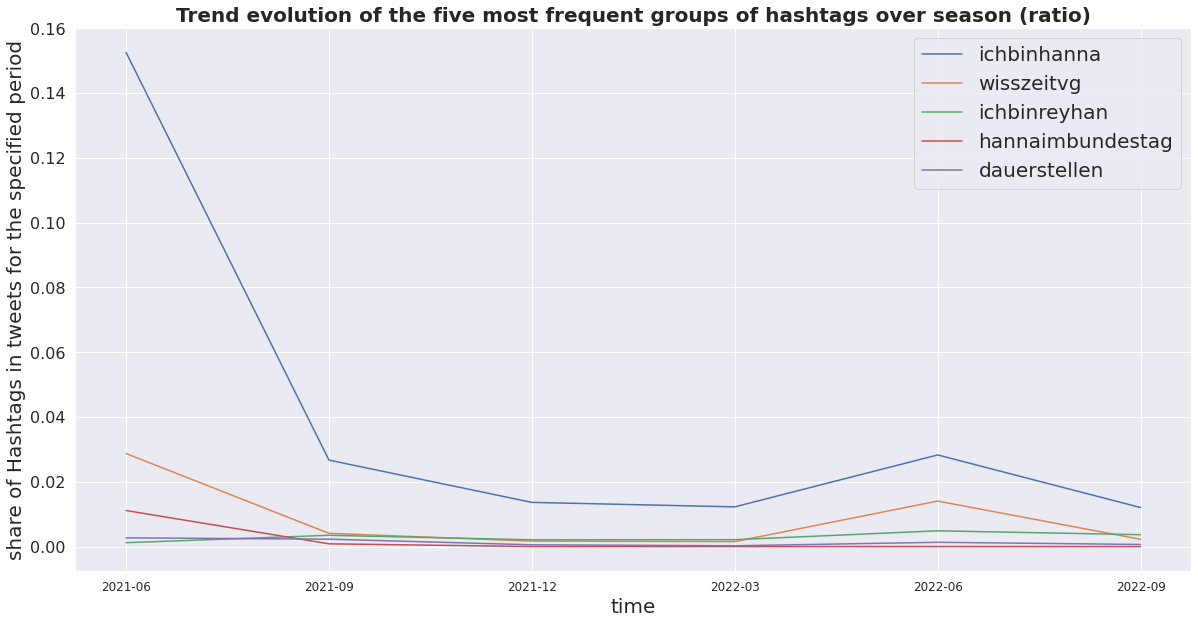

In [ ]:
%matplotlib inline
sns.set(style="darkgrid")
fig = plt.figure(figsize = (20, 10))
for i in new_hash_set[0:5]:
  plt.plot(date_each3,np.array(group_hash_numlist(clustered_hashtags[i]))/np.size(list_of_all_hashtags))#/summ

plt.legend([f'{representative_hashtgas[i]}' for i in new_hash_set[0:5]], fontsize=20) 
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 16)

plt.xlabel("time",fontsize = 20)
plt.ylabel("share of Hashtags in tweets for the specified period",fontsize = 20)
plt.title("Trend evolution of the five most frequent groups of hashtags over season (ratio)",fontsize = 20,fontweight='bold')
plt.show()


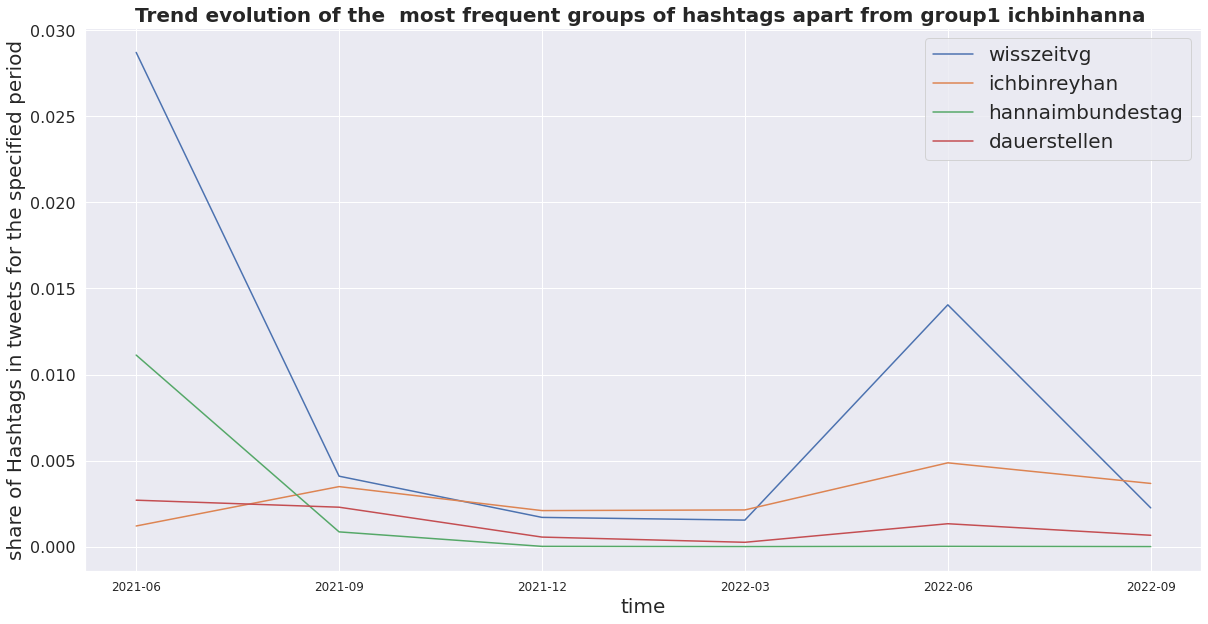

In [ ]:
%matplotlib inline
sns.set(style="darkgrid")
fig = plt.figure(figsize = (20, 10))
for i in new_hash_set[1:5]:
  plt.plot(date_each3,np.array(group_hash_numlist(clustered_hashtags[i]))/np.size(list_of_all_hashtags))#/summ

plt.legend([f'{representative_hashtgas[i]}' for i in new_hash_set[1:5]], fontsize=20) 
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 16)

plt.xlabel("time",fontsize = 20)
plt.ylabel("share of Hashtags in tweets for the specified period",fontsize = 20)
plt.title("Trend evolution of the  most frequent groups of hashtags apart from group1 ichbinhanna ",fontsize = 20,fontweight='bold')
plt.show()


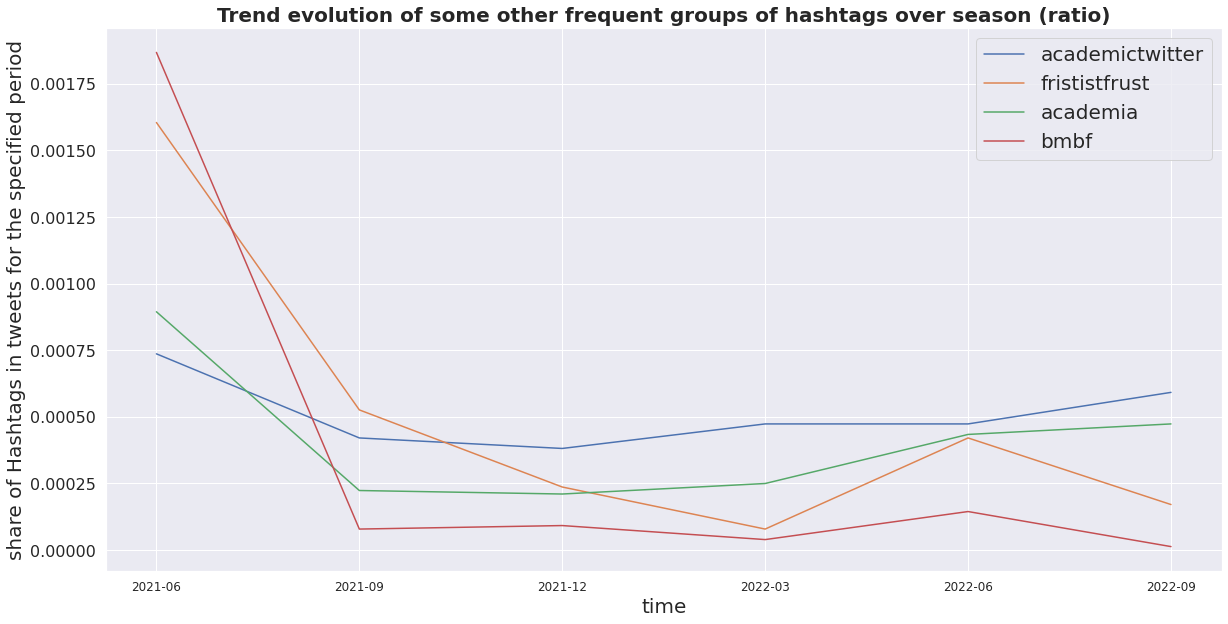

In [ ]:
%matplotlib inline
sns.set(style="darkgrid")
fig = plt.figure(figsize = (20, 10))
for i in new_hash_set[6:11]:
  plt.plot(date_each3,np.array(group_hash_numlist(clustered_hashtags[i]))/np.size(list_of_all_hashtags))#/summ

plt.legend([f'{representative_hashtgas[i]}' for i in new_hash_set[6:11]], fontsize=20) 
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 16)

plt.xlabel("time",fontsize = 20)
plt.ylabel("share of Hashtags in tweets for the specified period",fontsize = 20)
plt.title("Trend evolution of some other frequent groups of hashtags over season (ratio)",fontsize = 20,fontweight='bold')
plt.show()


In [ ]:
df = pd.read_parquet("rep_hash.parquet")

In [ ]:
df

,group_name,group_hash
0,wisszeitvg,"[tvstud, bildung, scholz, nichtemma, lenzen, d..."
1,ichbinhanna,"[phdlife, woisthanna, ichbinhannah, hannawählt..."
2,dauerstellen,"[befristungen, dauerstellen, befristung, entfr..."
3,weilwirwissenschaftlieben,"[womeninscience, openaccess, weilwirwissenscha..."
4,academictwitter,"[academics, mentalhealth, academictwitter, aca..."
5,streik,"[streiksemester, arbeitszeiterfassung, streik,..."
6,ichbinhannaat,"[baerbock, bipoc, ichbinhannaat, wissmobb]"
7,wissenschaftsfreiheit,"[wissenschaftssystem, wissenschaftspolitik, wi..."
8,academia,"[klassismus, classmatters, academia, academicc..."
9,diversity,"[diversität, diversity, universität, universit..."


In [ ]:
representative_hashtgas =list(df.group_name)
clustered_hashtags=list(df.group_hash)

In [ ]:
df.style.set_properties(**{'border': '22px solid  #eee',"font-size":"18px" ,"padding":"1px 35px","font-family" : 'Times New Roman',"border-collapse" : "collapse" ,'text-align': "center",'vertical-align': "center" ,"headers": {'props': { "background-color": "blue", "color": "white"}}
                          })


In [ ]:
s = df.style

In [ ]:

index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
s.set_table_styles([ index_names])
s.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'font-size: 1.5em;text-align: center;'},
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.5em;font-family : Times New Roman;'},
    {'selector': 'td', 'props': 'font-size: 1.4em;font-family : Times New Roman;text-align: center; font-weight: bold;'},
], overwrite=False)

,group_name,group_hash
0,wisszeitvg,['tvstud' 'bildung' 'scholz' 'nichtemma' 'lenzen' 'daad' 'spd' 'gutearbeit' 'tdl' 'wisszeitvg' 'krankenkassen' 'studium' 'lehre' 'wisskomm' 'laschet' 'karliczek' 'nachwuchs' 'zeitverträge' 'mittelbau' 'gew' 'tvstudjetzt' 'karriere' 'jlugiessen' 'germany' 'lanz' 'wissenschaftler' 'trump' 'unigöttingen' 'arbeiterkind' 'twitterstorians' 'job' 'lewandowski' 'forschung' 'promotion' 'ampel' 'wissenschaft' 'twittercampus' 'promovieren' 'freibad']
1,ichbinhanna,['phdlife' 'woisthanna' 'ichbinhannah' 'hannawählt' 'hannafürberlhg' 'dfg' 'berlhg' 'hrk' 'ichwarhanna' 'ichbinhannach' 'hanna' 'mehrhabeck' 'ichbinhanna' 'germanacademia' 'wirsindhanna' 'bafög' 'göttingen']
2,dauerstellen,['befristungen' 'dauerstellen' 'befristung' 'entfristung' 'dauerstellenfürdaueraufgaben' 'anschlussverwendung' 'daueraufgaben' 'keineausnahme' 'zwangsteilzeit' 'entfristethanna']
3,weilwirwissenschaftlieben,['womeninscience' 'openaccess' 'weilwirwissenschaftlieben' 'sciencesunday' 'openscience' 'science' 'wissenschaftlerinnen']
4,academictwitter,['academics' 'mentalhealth' 'academictwitter' 'academicprecarity' 'academicmentalhealth']
5,streik,['streiksemester' 'arbeitszeiterfassung' 'streik' 'ausstieghochschule']
6,ichbinhannaat,['baerbock' 'bipoc' 'ichbinhannaat' 'wissmobb']
7,wissenschaftsfreiheit,['wissenschaftssystem' 'wissenschaftspolitik' 'wissenschaftsfreiheit' 'wissenschaftszeitvertragsgesetz']
8,academia,['klassismus' 'classmatters' 'academia' 'academicchatter']
9,diversity,['diversität' 'diversity' 'universität' 'universitäten']
